In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import warnings
warnings.filterwarnings('ignore')

x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)
# del X_train,X_test

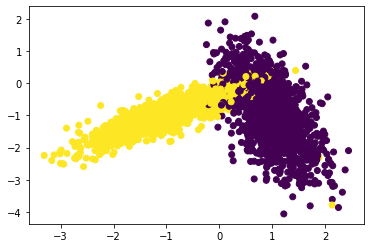

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(x_test[:,0], x_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [8]:
from sklearn.metrics import accuracy_score
from numpy.random import seed
from numpy.random import randint

def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    trainscores=[]
    testscores=[]
    params=[]
    
    seed(1)
    params=randint(param_range[0],param_range[1],10)
    params.sort()
    #print(params)
    
    c=len(x_train)//folds

    for k in tqdm(params):
        trainscores_folds=[]
        testscores_folds=[]
        for i in range(folds):
            
            if i==0:
                train_indices=list(set(list(range(0,len(x_train))))-set(range(c*i,min(c*(i+1),len(x_train)))))
                test_indices=list(range(c*i,min(c*(i+1),len(x_train))))
                #print(c*i,min(c*(i+1),len(x_train)))
            else:
                train_indices=list(set(list(range(0,len(x_train))))-set(range(c*i+1,min(c*(i+1),len(x_train)))))
                test_indices=list(range(c*i+1,min(c*(i+1),len(x_train))))
                #print(c*i+1,min(c*(i+1),len(x_train)))
            
            X_train=x_train[train_indices]
            Y_train=y_train[train_indices]
            X_test=x_train[test_indices]
            Y_test=y_train[test_indices]
            
            classifier.n_neighbors=k
            classifier.fit(X_train,Y_train)
            
            Y_predicted=classifier.predict(X_test)
            testscores_folds.append(accuracy_score(Y_predicted,Y_test))
            
            Y_predicted=classifier.predict(X_train)
            trainscores_folds.append(accuracy_score(Y_predicted,Y_train))
        
        trainscores.append(np.mean(np.array(trainscores_folds)))
        testscores.append(np.mean(np.array(testscores_folds)))
    
    return trainscores,testscores,params

100%|██████████| 10/10 [01:45<00:00, 10.54s/it]


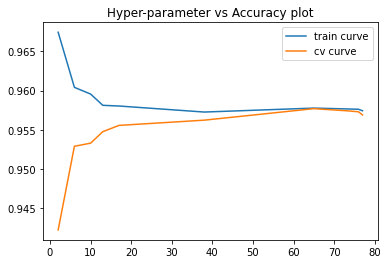

In [9]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random

neigh=KNeighborsClassifier()

param_range=(1,80)
folds=10

train_score,cv_score,params=RandomSearchCV(x_train,y_train,neigh, param_range, folds)

plt.plot(params,train_score,label='train curve')
plt.plot(params,cv_score,label='cv curve')
plt.title('Hyper-parameter vs Accuracy plot')
plt.legend()
plt.show()

In [10]:
def plot_decision_boundary(x1,x2,y,classifier):
    cmap_light=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold=ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min,x_max=x1.min()-1,x1.max()+1
    y_min,y_max=x2.min()-1,x2.max()+1
    
    xx,yy=np.meshgrid(np.arange(x_min,x_max,0.02),np.arange(y_min,y_max,0.02))
    Z=classifier.predict(np.c_[xx.ravel(),yy.ravel()])
    Z=Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx,yy,Z,cmap=cmap_light)
    plt.scatter(x1,x2,c=y,cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (classifier.n_neighbors))
    plt.show()

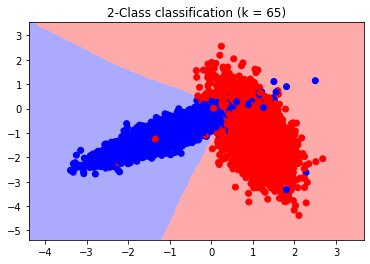

In [11]:
from matplotlib.colors import ListedColormap

neigh=KNeighborsClassifier(n_neighbors=65)
neigh.fit(x_train,y_train)
plot_decision_boundary(x_train[:, 0],x_train[:, 1],y_train,neigh)